<a href="https://colab.research.google.com/github/davearch/stock-price-prediction-machine-learning/blob/master/Stock_Price_Prediction_with_various_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.45-cp36-none-any.whl size=14652 sha256=f7384eb7c414d052ca39f5fa67d378bfce732450da196a41b53931787c4df851
  Stored in directory: /tmp/pip-ephem-wheel-cache-23tedf87/wheels/0c/d1/df/aa9a7744a4ac353cc9a1f2c3aaea7c1f457fc49de4286f2d88
Successfully built yfinance


In [3]:
# download stock data to my google drive
from google.colab import drive
drive.mount('drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [4]:
# import stock data from yahoo
# Looking at Bitcoin prices
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("BTC-USD", start="2010-07-16").reset_index()
df.to_csv('BTC_USD.csv', index=False)
df.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [5]:
# replace numerical index with Date field
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


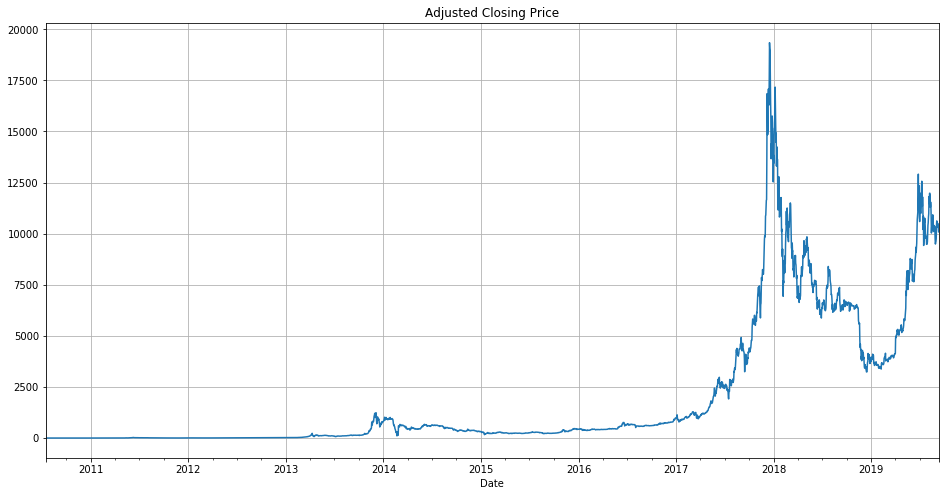

In [6]:
df['Adj Close'].plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # look at 32 days in the past
# we will have 32 day data windows and predict the 33rd day

# get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # create 2D matrix of training samples

In [0]:
X = data[:,:-1] # each row represents 32 days in the past
Y = data[:,-1] # each output value represents the 33rd day

In [0]:
# train and test split - 80% training 20% testing
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
Y_train = Y[:ind_split]
X_test = X[ind_split:]
Y_test = Y[ind_split:]

# Ridge Regression

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, Y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

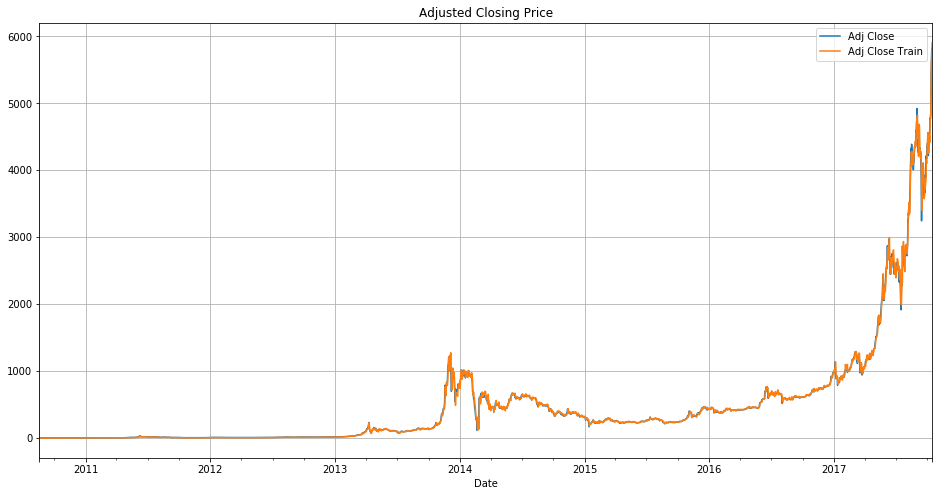

In [12]:
# plot
df_ridge = df.copy()
df_ridge.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label="BTC-USD", figsize=(16, 8), title='Adjusted Closing Price', grid=True)

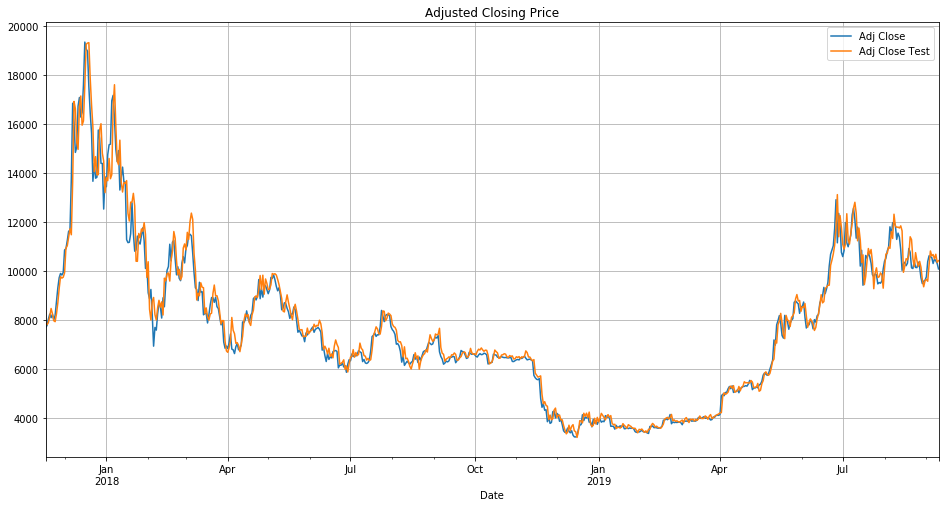

In [13]:
# test
df_ridge = df.copy()
df_ridge.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # past 32 days we don't know
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Lasso Regression

In [0]:
# train
lasso_model = Lasso(alpha=0.1, tol=0.01)
lasso_model.fit(X_train, Y_train)

# infer
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_lasso = lasso_model.predict(X_test)

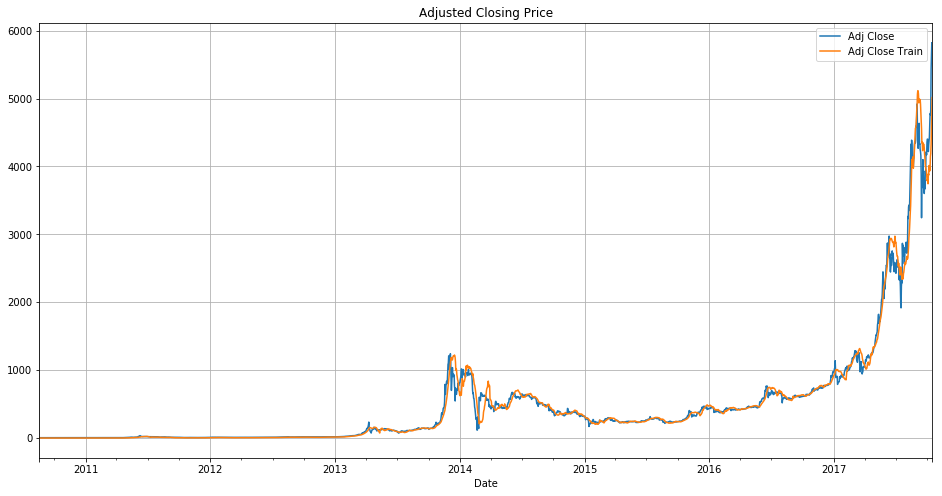

In [15]:
# plot lasso training
df_lasso = df.copy()
df_lasso.drop(['Open', 'High','Low','Close','Volume'], axis=1, inplace=True)
df_lasso = df_lasso.iloc[window_size:ind_split]
df_lasso['Adj Close Train'] = y_pred_train_lasso[:-window_size]
df_lasso.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

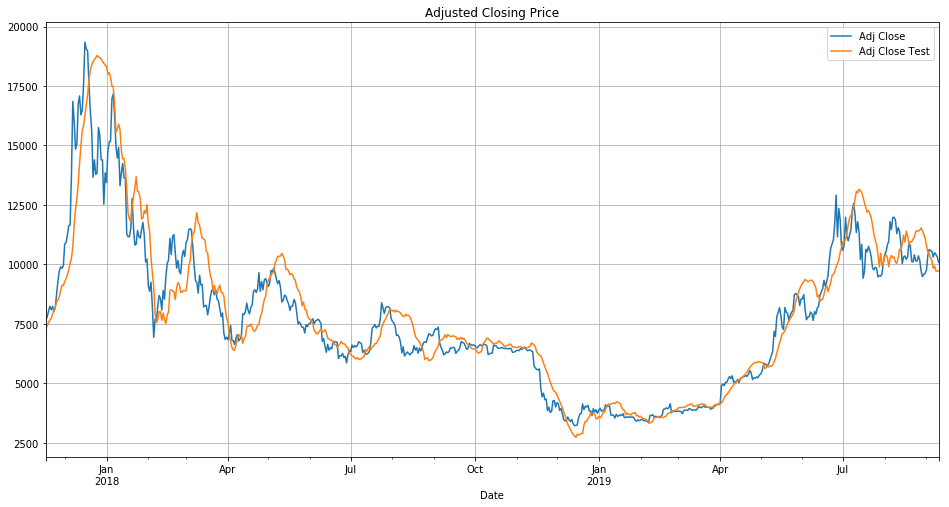

In [16]:
# plot lasso testing
df_lasso = df.copy()
df_lasso.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
df_lasso = df_lasso.iloc[ind_split+window_size:]
df_lasso['Adj Close Test'] = y_pred_lasso
df_lasso.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Gradient Boosting Trees

In [17]:
# Gradient Boosting Trees

# tune hyperparameters first via grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4,6],
    'min_samples_leaf': [3, 5, 9, 17],
    'max_features': [1.0, 0.3, 0.1]
}

gb_model = GradientBoostingRegressor(n_estimators=300)
gs_cv = GridSearchCV(gb_model, param_grid).fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
# optimized hyper parameters
lr = gs_cv.best_params_['learning_rate']
md = gs_cv.best_params_['max_depth']
mf = gs_cv.best_params_['max_features']
msl = gs_cv.best_params_['min_samples_leaf']
optimized_gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=lr, max_depth=md, max_features=mf, min_samples_leaf=msl)
optimized_gb_model.fit(X_train, Y_train)

# infer
y_pred_train_gb = optimized_gb_model.predict(X_train)
y_pred_gb = optimized_gb_model.predict(X_test)

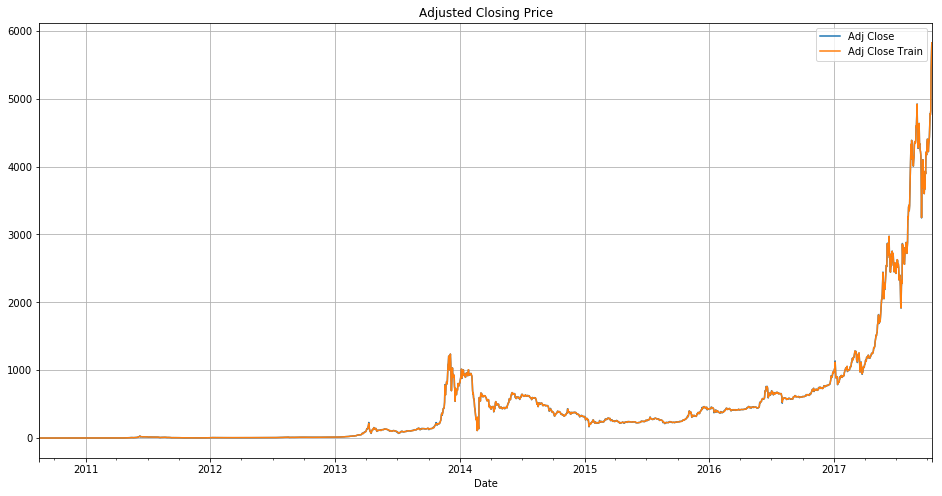

In [19]:
# plot training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='BTC_USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

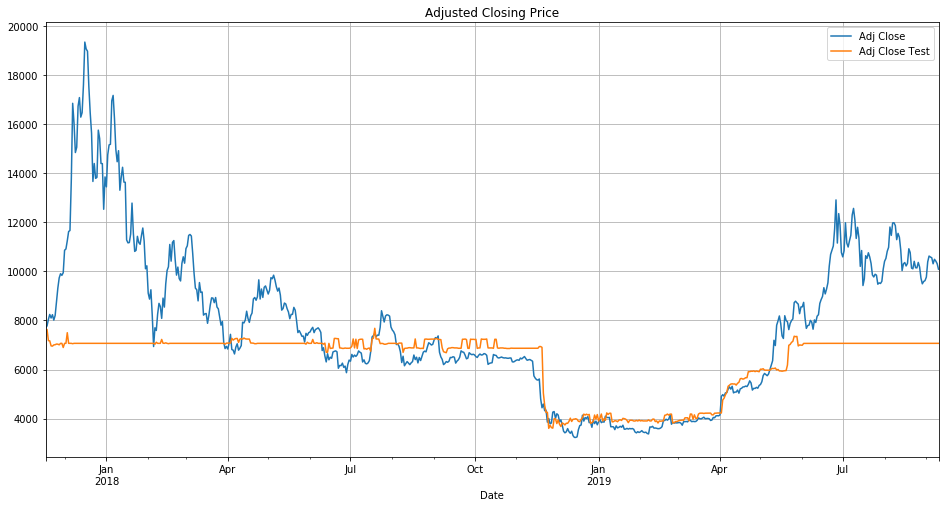

In [20]:
# test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # past 32 days
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Neural Networks with 1D convolutional and LSTM

In [21]:
# RNNs
keras_model = Sequential([
    Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
    Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation="tanh"),
    Dense(64, activation="tanh"),
    Dense(1)
])
keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

In [22]:
# find a learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                   optimizer=optimizer,
                   metrics=['mae'])
# scale date due to LSTM units
scaler = MinMaxScaler(feature_range=(-1,1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
Y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
Y_train_reshape = Y2[:ind_split]
X_test_reshape = X2[ind_split:]
Y_test_reshape = Y2[ind_split:]

In [23]:
history = keras_model.fit(X_train_reshape, Y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, Y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2648 samples, validate on 663 samples
Epoch 1/250
2648/2648 [==============================] - 11s 4ms/step - loss: 0.4314 - mean_absolute_error: 0.9229 - val_loss: 0.0694 - val_mean_absolute_error: 0.3127
Epoch 2/250
2648/2648 [==============================] - 2s 729us/step - loss: 0.4314 - mean_absolute_error: 0.9229 - val_loss: 0.0694 - val_mean_absolute_error: 0.3127
Epoch 3/250
2648/2648 [==============================] - 2s 705us/step - loss: 0.4314 - mean_absolute_error: 0.9229 - val_loss: 0.0694 - val_mean_absolute_error: 0.3127
Epoch 4/250
2648/2648 [==============================] - 2s 707us/step - loss: 0.4314 - mean_absolute_error: 0.9229 - val_loss: 0.0694 - val_mean_absolute_error: 0.3127
Epoch 5/250
2648/2648 [==============================] - 2s 712us/step - loss: 0.4314 - mean_absolute_error: 0.9229 - val_loss: 0.0694 - val_mean_absolute_error: 0.3127
Epoch 6/250
2

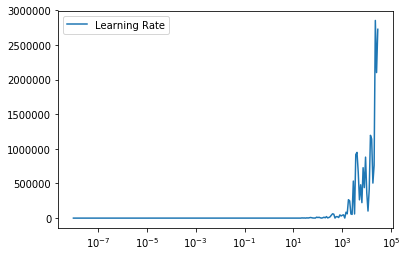

In [24]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

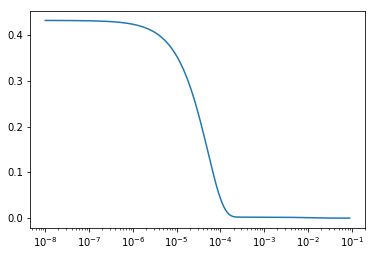

In [25]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [26]:
# use 0.1 learning rate
keras_model = Sequential([
    Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
    Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation="tanh"),
    Dense(64, activation="tanh"),
    Dense(1)
])

optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                   optimizer=optimizer,
                   metrics=["mae"])
history = keras_model.fit(X_train_reshape, Y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, Y_test_reshape))

Train on 2648 samples, validate on 663 samples
Epoch 1/250
2648/2648 [==============================] - 4s 1ms/step - loss: 0.1141 - mean_absolute_error: 0.3795 - val_loss: 0.2911 - val_mean_absolute_error: 0.7132
Epoch 2/250
2648/2648 [==============================] - 2s 778us/step - loss: 0.0134 - mean_absolute_error: 0.1294 - val_loss: 0.3476 - val_mean_absolute_error: 0.7913
Epoch 3/250
2648/2648 [==============================] - 2s 796us/step - loss: 0.0073 - mean_absolute_error: 0.0800 - val_loss: 0.2771 - val_mean_absolute_error: 0.6907
Epoch 4/250
2648/2648 [==============================] - 2s 815us/step - loss: 0.0055 - mean_absolute_error: 0.0635 - val_loss: 0.2574 - val_mean_absolute_error: 0.6641
Epoch 5/250
2648/2648 [==============================] - 2s 754us/step - loss: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.2241 - val_mean_absolute_error: 0.6158
Epoch 6/250
2648/2648 [==============================] - 2s 769us/step - loss: 0.0043 - mean_absolute_error: 0

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

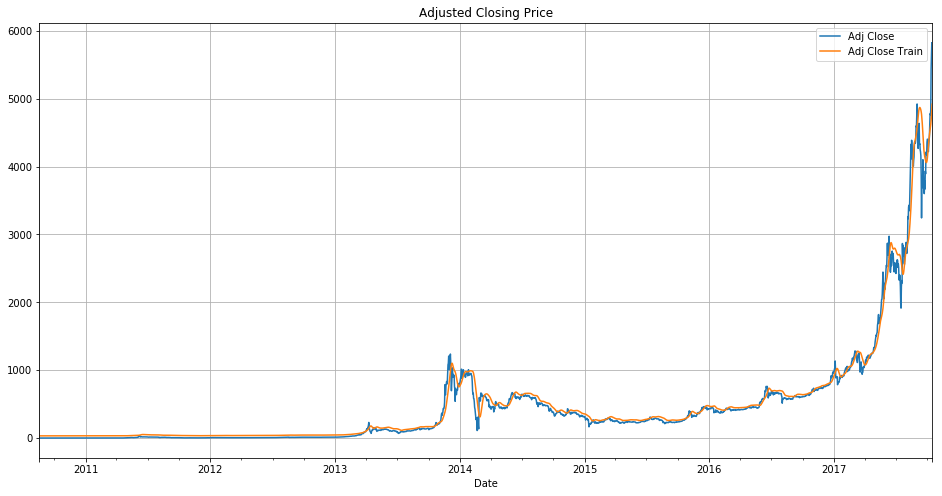

In [28]:
# plot training
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # past 32 days
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

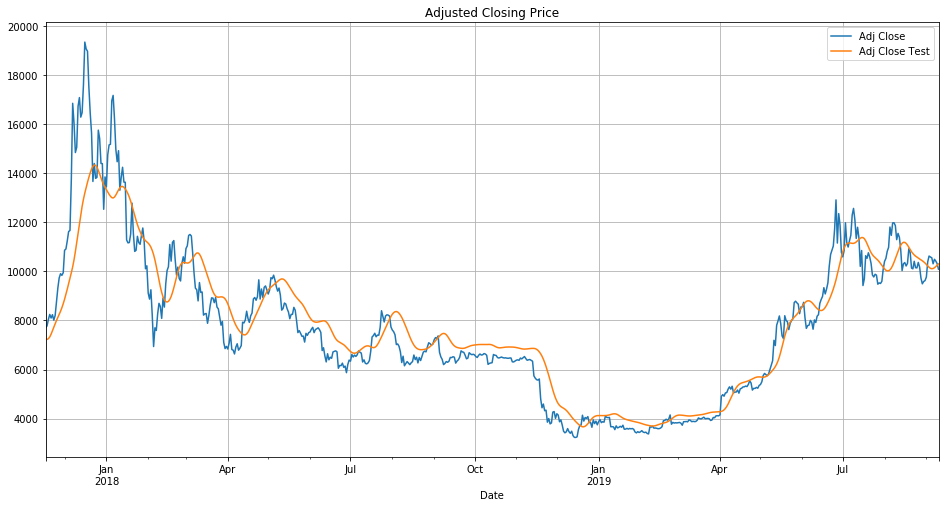

In [29]:
# plot test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # past 32 days
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

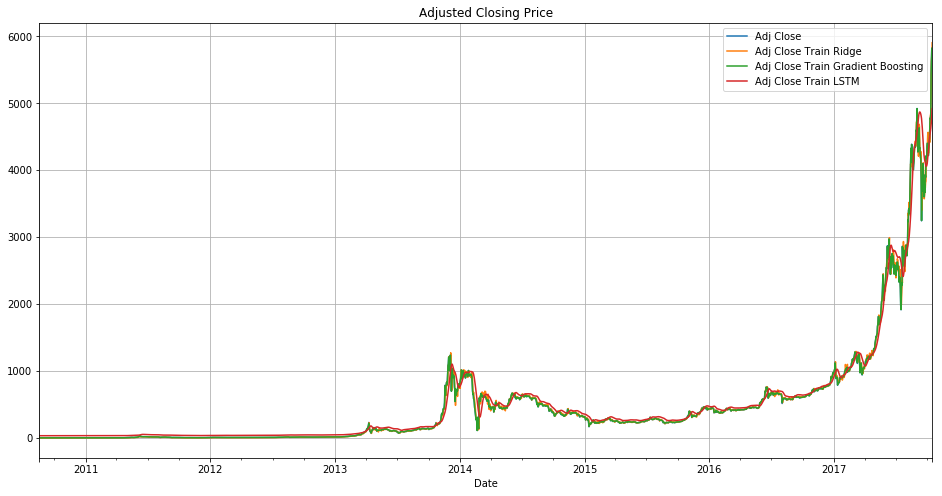

In [30]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # past 32 days we don't know
# add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# plot data
df_train.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

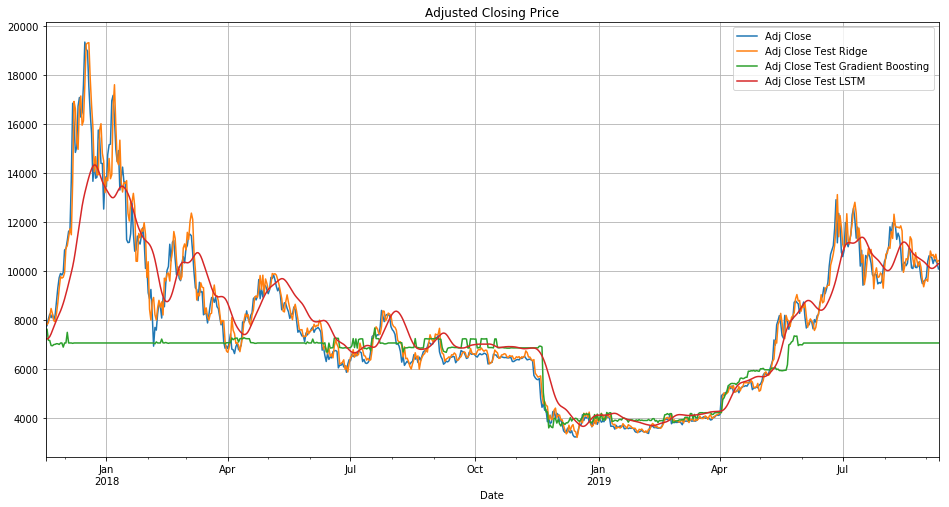

In [31]:
# plot all testing data
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:]
# add in all methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# plot
df_test.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

# Prediction

In [0]:
num_days = 10 # predict next 10 days

# get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days):
  values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
  values["gb"].append(optimized_gb_model.predict(input_values["gb"])[0])
  values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])
  
  # dump the oldest price and put the newest price at the end
  for v in input_values:
    val = input_values[v]
    val = np.insert(val, -1, values[v][-1], axis=1)
    val = np.delete(val, 0, axis=1)
    input_values[v] = val.copy()
    
# convert all to NumPy arrays
for v in input_values:
  values[v] = np.array(values[v])
  
# unnormalize prices from NN approach
values['keras'] = scaler.inverse_transform(values['keras'][None])[0]

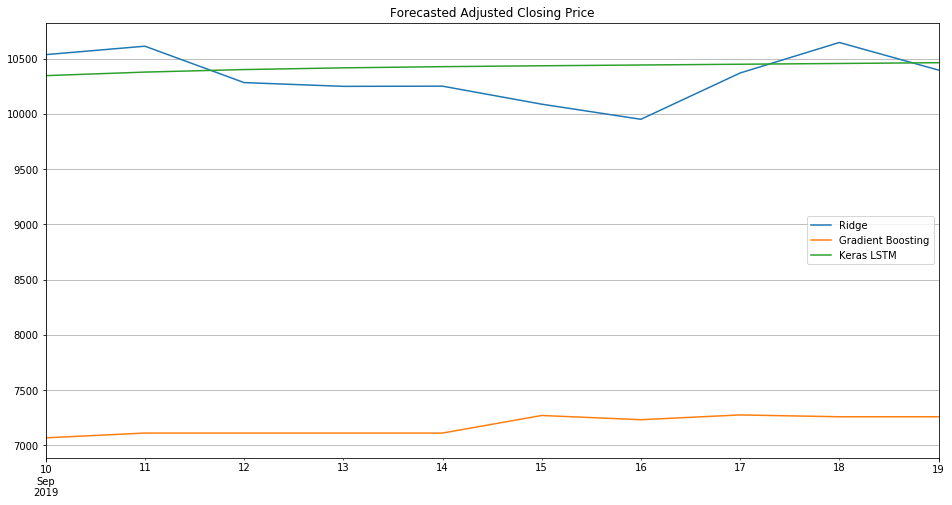

In [33]:
# plot next 10 days
from datetime import timedelta, datetime
today = str(df.index[-1])
last_date = datetime.strptime(today[:10], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start = last_date, periods=num_days)
df_forecast.plot(label='BTC-USD', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)